In [2]:
"""
====================================
Comparing models for sequential data
====================================

How to train mixtures and HMMs with various observation models on the same dataset.

"""
# sphinx_gallery_thumbnail_number = 1

import bnpy
import numpy as np
import os

from matplotlib import pylab
import seaborn as sns

SMALL_FIG_SIZE = (2.5, 2.5)
FIG_SIZE = (5, 5)
pylab.rcParams['figure.figsize'] = FIG_SIZE


In [3]:
dataset_path = os.path.join(bnpy.DATASET_PATH, 'mocap6')
dataset = bnpy.data.GroupXData.read_npz(
    os.path.join(dataset_path, 'dataset.npz'))

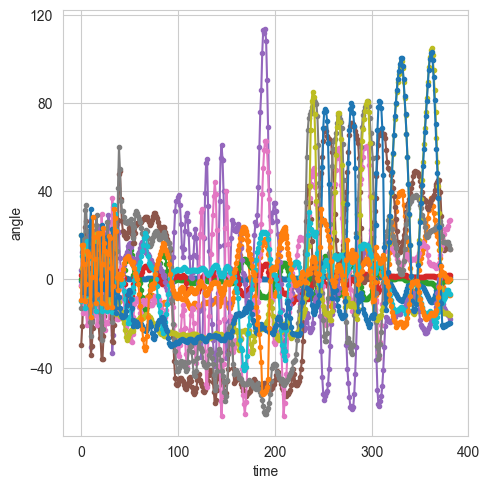

In [4]:
def show_single_sequence(seq_id):
    start = dataset.doc_range[seq_id]
    stop = dataset.doc_range[seq_id + 1]
    for dim in range(12):
        X_seq = dataset.X[start:stop]
        pylab.plot(X_seq[:, dim], '.-')
    pylab.xlabel('time')
    pylab.ylabel('angle')
    pylab.tight_layout()

show_single_sequence(0)

In [5]:
from hmmlearn.hmm import GaussianHMM
from bnpy import HModel

def normalize_matrix(matrix):
    matrix += 1e-40
    return matrix / np.sum(matrix, axis=(matrix.ndim - 1), keepdims=True)

def get_hmm_learn_from_bnpy(some_model: HModel):

    obs_model = some_model.obsModel
    total_k = obs_model.K
    means = []
    sigmas = []
    for k in range(total_k):
        sigmas.append(np.diag(obs_model.get_covar_mat_for_comp(k)))
        means.append(obs_model.get_mean_for_comp(k))

    means = np.vstack(means)
    sigmas = np.vstack(sigmas)

    A = some_model.allocModel.get_trans_prob_matrix(),
    pi = some_model.allocModel.get_init_prob_vector(),

    # return A, pi,

    # creat hmm
    hmm_bnpy = GaussianHMM(n_components=len(pi[0]), covariance_type='diag', init_params='')
    hmm_bnpy.n_features = means.shape[1]
    hmm_bnpy.transmat_, hmm_bnpy.startprob_, hmm_bnpy.means_ = normalize_matrix(A[0]), normalize_matrix(pi[0]), means
    hmm_bnpy.covars_ = sigmas
    return hmm_bnpy

def get_hmm_from_bnpy(some_model: HModel, name=None):

    obs_model = some_model.obsModel
    total_k = obs_model.K
    means = []
    sigmas = []
    for k in range(total_k):
        sigmas.append(np.diag(obs_model.get_covar_mat_for_comp(k)))
        means.append(obs_model.get_mean_for_comp(k))

    means = np.vstack(means)
    sigmas = np.vstack(sigmas)

    return_val = {
        'A': some_model.allocModel.get_trans_prob_matrix(),
        'pi': some_model.allocModel.get_init_prob_vector(),
        'alloc': some_model.allocModel.to_dict(),
        'obs': some_model.obsModel.to_dict(),
        'means': means,
        'covars': sigmas
     }

    if name:
        directory_path = "/Users/david/Documents/mastersCode/ubm/final/tests/get_features/"
        file_name = 'humpback_v1_bnpy_' + name + '.pkl'
        output = open(directory_path + file_name, "wb")
        pickle.dump(return_val, output)
        output.close()

    return return_val

import matplotlib.pyplot as plt

def plot_results_dict(data_dict, title=None):
    keys = list(data_dict.keys())
    values = list(data_dict.values())

    # Plotting
    plt.plot(keys, values, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('N components')
    plt.ylabel('ll')
    plt.show()

def get_GroupXData_from_list(features_list):
    features_concat = np.vstack(features_list)
    features_len = [0]
    n_doc = 0
    rolling_total = 0

    for i in range(len(features_list)):
        features_len.append(len(features_list[i]) + rolling_total)
        rolling_total += len(features_list[i])
        n_doc += 1

    features_len = np.array(features_len)

    return bnpy.data.GroupXData(X=features_concat, doc_range=features_len,
                                          nDocTotal=n_doc)

from hmmlearn.vhmm import VariationalGaussianHMM
from hmmlearn.base import BaseHMM
from hmmlearn.hmm import GaussianHMM

def score_hmm(score_hmm: BaseHMM, features_array):
    scores = []
    for i in range(len(features_array)):
        scores.append(score_hmm.score(features_array[i]) / len(features_array[i]))
    print(np.sum(scores))
    return np.sum(scores)

class MyGroupXData:
    def __init__(self, X, TrueParams, Xprev, column_names, dim, doc_range, nDoc, nDocTotal, true_state_names):
        self.X = X
        self.TrueParams = TrueParams
        self.Xprev = Xprev
        self.column_names = column_names
        self.dim = dim
        self.doc_range = doc_range
        self.nDoc = nDoc
        self.nDocTotal = nDocTotal
        self.true_state_names = true_state_names

In [6]:
#
# Setup: hyperparameters
# ----------------------------------------------------------

K = 20            # Number of clusters/states

gamma = 5.0       # top-level Dirichlet concentration parameter
transAlpha = 0.5  # trans-level Dirichlet concentration parameter
startAlpha = 2

sF = 1.0          # Set observation model prior so E[covariance] = identity
ECovMat = 'eye'

In [7]:
import pickle

dataset_path = os.path.join(bnpy.DATASET_PATH, 'mocap6')
dataset = bnpy.data.GroupXData.read_npz(
    os.path.join(dataset_path, 'dataset.npz'))

bnpy_dataset = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/tests/get_features/humpback_v1_bnpy_dataset.pkl', 'rb'))
bnpy_dataset_val = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/tests/get_features/humpback_v1_bnpy_dataset_val.pkl', 'rb'))
humpback_cv_output = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/tests/get_features/humpback_cv_output.pkl', 'rb'))

bnpy_dataset_group = bnpy.data.GroupXData(X=bnpy_dataset.X, doc_range=bnpy_dataset.doc_range,
                                          nDocTotal=bnpy_dataset.nDocTotal)

val_features = bnpy_dataset_val[1]


In [8]:
# curr_test = humpback_cv_output['test_data']
ns = np.arange(1,30,1)
aic = []
bic = []
lls = []
lls_train = []
dict_results = {}
for n in ns:
    best_ll = None
    best_model = None
    best_index = None
    print('calculating for n: ', n)
    for cv_index in range(len(humpback_cv_output['train_data'])):
        curr_train = humpback_cv_output['train_data'][cv_index]
        curr_val = humpback_cv_output['val_data'][cv_index]
        curr_hmm = GaussianHMM(n_components=n, covariance_type='diag')
        curr_hmm.fit(np.concatenate(curr_train))
        score = curr_hmm.score(np.concatenate(curr_val))
        if not best_ll or best_ll < best_ll:
            best_ll = score
            best_model = curr_hmm
            best_index = cv_index
    aic.append(best_model.aic(np.concatenate(humpback_cv_output['val_data'][best_index])))
    bic.append(best_model.bic(np.concatenate(humpback_cv_output['val_data'][best_index])))
    lls.append(best_model.score(np.concatenate(humpback_cv_output['val_data'][best_index])))
    lls_train.append(best_model.score(np.concatenate(humpback_cv_output['train_data'][best_index])))

calculating for n:  1
calculating for n:  2
calculating for n:  3
calculating for n:  4


KeyboardInterrupt: 

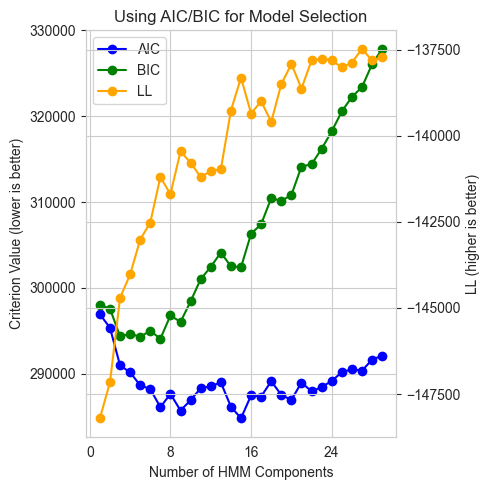

In [30]:
fig, ax = plt.subplots()
ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")
# ln4 = ax2.plot(ns, lls_train, label="LL_train", color="yellow", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()
plt.show()

# run VI on finite HMM, plot ELBO

In [32]:
# plt.errorbar(ns, np.gradient(bic), label='BIC')
# plt.errorbar(ns, np.gradient(aic), label='AIC')
# plt.title("Gradient of BIC Scores", fontsize=20)
# # plt.xticks(ns)
# plt.xlabel("N. of clusters")
# plt.ylabel("grad(BIC)")
# plt.legend()

In [8]:
atest = humpback_cv_output['train_data'][0]

test_hmm = GaussianHMM(4)

In [ ]:
test_hmm.fit(atest[0])

In [11]:
test_hmm.aic(atest[0])

62158.73311389061

In [115]:
# 1 finite EM HMM, with different components init
cv_results = {}
for cv_index in range(len(humpback_cv_output['train_data'])):

    curr_train = humpback_cv_output['train_data'][cv_index]
    curr_train = get_GroupXData_from_list(curr_train)
    n_components = [5,50,100,150]
    em_results = {}
    for i in range(len(n_components)):
        print('training em for', n_components[i], 'components')
        hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
            curr_train, 'FiniteHMM', 'DiagGauss', 'EM',
            output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
            nLap=50, nTask=1, nBatch=1, convergeThr=0.0001, startAlpha=startAlpha,
            transAlpha=transAlpha, hmmKappa=10, sF=sF, ECovMat=ECovMat,
            K=n_components[i], initname='randexamples',
            )
        some_hmm = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
        em_results[n_components[i]] = score_hmm(some_hmm, humpback_cv_output['val_data'][cv_index])
    cv_results[cv_index] = em_results

training em for 5 components
  --nBatch
Dataset Summary:
GroupXData
  size: 23 units (documents)
  dimension: 129
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 131  ...
  beta = [ 129  129]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 5 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: EM | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/1
        1/50 after      0 sec. |    952.5 MiB | K    5 | loss  2.912827715e+08 |  
        2/50 after      0 sec. |    952.6 MiB | K    5 | loss  2.051692628e+00 | Ndiff  517.192 
        3/50 after      0 sec. |    952.6 MiB | K    5 | loss  2.023296297e+00 | Ndiff  135.230 
        4/50 after      0 sec. |    952

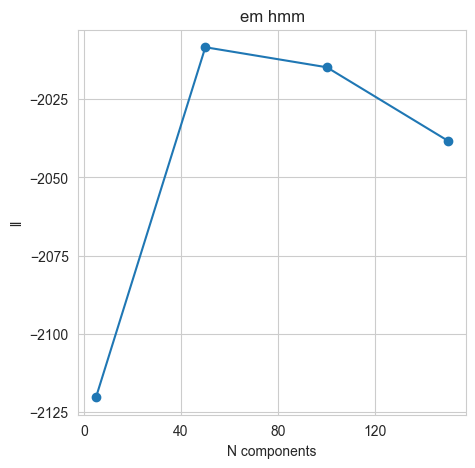

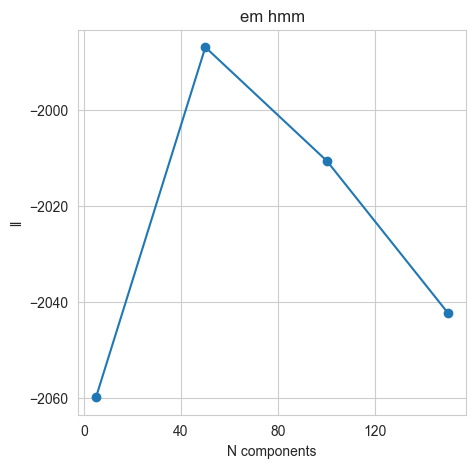

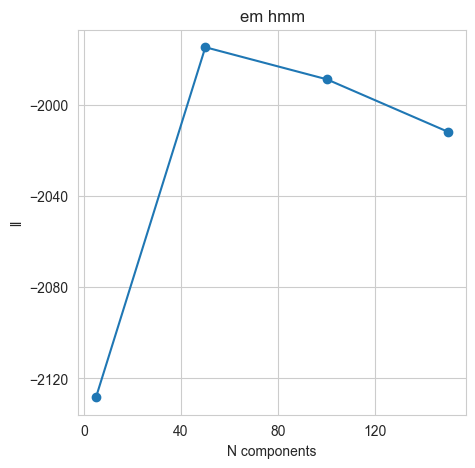

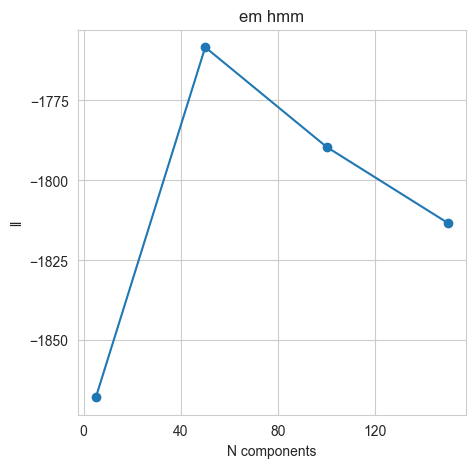

In [116]:
for key in cv_results:
    plot_results_dict(cv_results[key], 'em hmm')

In [48]:
# 1 finite VI HMM, with different components init
cv_results_vi = {}
loss_info_vi = {}
for cv_index in range(len(humpback_cv_output['train_data'])):
    print('cv index: ', cv_index)
    curr_train = humpback_cv_output['train_data'][cv_index]
    curr_train = get_GroupXData_from_list(curr_train)
    n_components = [5,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,40]
    em_results = {}
    models = {}
    loss_info = {}
    for i in range(len(n_components)):
        print('training em for', n_components[i], 'components')
        hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
            curr_train, 'FiniteHMM', 'DiagGauss', 'memoVB',
            output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
            nLap=80, nTask=1, nBatch=1, convergeThr=0.0001, startAlpha=startAlpha,
            transAlpha=transAlpha, hmmKappa=10, sF=sF, ECovMat=ECovMat,
            K=n_components[i], initname='randexamples',
            )
        some_hmm = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
        em_results[n_components[i]] = score_hmm(some_hmm, humpback_cv_output['val_data'][cv_index])
        models[n_components[i]] = hmmdiag_trained_model
        loss_info[n_components[i]] = hmmdiag_info_dict['loss']
    cv_results_vi[cv_index] = em_results
    loss_info_vi[cv_index] = loss_info

cv index:  0
training em for 5 components
Dataset Summary:
GroupXData
  total size: 25 units
  batch size: 25 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 131  ...
  beta = [ 129  129]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 5 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/1
    1.000/80 after      0 sec. |    755.1 MiB | K    5 | loss  2.101324787e+00 |  
    2.000/80 after      0 sec. |    755.1 MiB | K    5 | loss  2.081499231e+00 | Ndiff   68.624 
    3.000/80 after      0 sec. |    755.1 MiB | K    5 | loss  2.077552093e+00 | Ndiff   39.507 
    4.000/80 af

[0, 1, 2, 3, 4, 5]


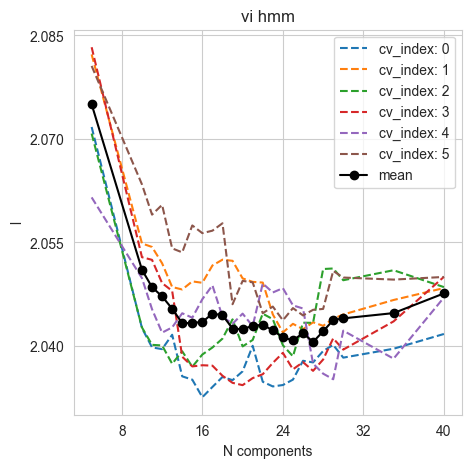

In [69]:
def plot_results_dict_cv(data_dict_cv, title=None):

    outer_keys = data_dict_cv.keys()

    print(list(outer_keys))

    num_dicts = len(outer_keys)

    sum_values = {key: 0 for key in data_dict_cv[list(outer_keys)[0]]}

    for key in outer_keys:
        data_dict = data_dict_cv[key]
        keys = list(data_dict.keys())
        values = list(data_dict.values())

        # Plotting
        plt.plot(keys, values, marker='', linestyle='--', label='cv_index: ' + str(key))
        plt.title(title)
        plt.xlabel('N components')
        plt.ylabel('l')
        plt.legend()

        for i in range(len(keys)):
            sum_values[keys[i]] += values[i]

    mean_values = {}
    for inner_key in sum_values.keys():
        mean_values[inner_key] = sum_values[inner_key] / num_dicts

    keys = list(mean_values.keys())
    values = list(mean_values.values())

    dy_dx = np.gradient(values, keys)

    plt.plot(keys, values, marker='o', linestyle='-', c='black', label='mean')
    # plt.plot(keys, dy_dx, label='Derivative')
    plt.title(title)
    plt.xlabel('N components')
    plt.ylabel('l')
    plt.legend()

    plt.show()
    return keys, dy_dx
x, y = plot_results_dict_cv(loss_info_vi, 'vi hmm')

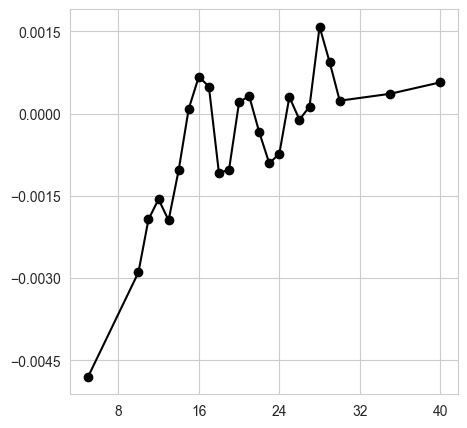

In [73]:
plt.plot(x,y,marker='o', linestyle='-', c='black', label='mean')

In [ ]:

plot_results_dict_cv(cv_results_vi, 'vi hmm')

TypeError: 'dict_keys' object is not subscriptable

-4313.725468559418


In [76]:
hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
    bnpy_dataset_group, 'FiniteHMM', 'DiagGauss', 'EM',
    output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
    nLap=50, nTask=1, nBatch=1, convergeThr=0.0001, startAlpha=startAlpha,
    transAlpha=transAlpha, hmmKappa=10, sF=sF, ECovMat=ECovMat,
    K=10, initname='randexamples',
    )

_ = get_hmm_from_bnpy(hmmdiag_trained_model, 'finite_em')

  --nBatch
Dataset Summary:
GroupXData
  size: 15 units (documents)
  dimension: 129
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 131  ...
  beta = [ 129  129]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 10 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: EM | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/1
        1/50 after      0 sec. |    215.0 MiB | K   10 | loss  3.206241178e+08 |  
        2/50 after      0 sec. |    215.0 MiB | K   10 | loss  2.010002916e+00 | Ndiff  198.441 
        3/50 after      0 sec. |    215.0 MiB | K   10 | loss  1.976959146e+00 | Ndiff  150.572 
        4/50 after      0 sec. |    215.0 MiB | K   10 | loss  1.95

In [39]:
goodelbopairs_merge_kwargs = dict(
    m_startLap = 10,
    # Set limits to number of merges attempted each lap.
    # This value specifies max number of tries for each cluster
    m_maxNumPairsContainingComp = 5,
    # Set "reactivation" limits
    # So that each cluster is eligible again after 10 passes thru dataset
    # Or when it's size changes by 400%
    m_nLapToReactivate = 10,
    m_minPercChangeInNumAtomsToReactivate = 400 * 0.01,
    # Specify how to rank pairs (determines order in which merges are tried)
    # 'obsmodel_elbo' means rank pairs by improvement to observation model ELBO
    m_pair_ranking_procedure = 'obsmodel_elbo',
    m_pair_ranking_direction = 'descending',
    )

init_kwargs = dict(
    K=20,
    initname='randexamples',
    )

alg_kwargs = dict(
    nLap=50,
    nTask=1, nBatch=1, convergeThr=0.0001,
    )

hdphmm_kwargs = dict(
    # startAlpha = 10.0,       # top-level Dirichlet concentration parameter
    transAlpha = 0.5,  # trans-level Dirichlet concentration parameter
    # hmmKappa = 5,
    gamma = 5,
    )

gauss_kwargs = dict(
    sF = 1,          # Set prior so E[covariance] = identity
    ECovMat = 'eye',
    )

inf_vi_loss = {}
inf_vi_ll = {}
for cv_index in range(len(humpback_cv_output['train_data'])):
    print('cv index: ', cv_index)
    curr_train = humpback_cv_output['train_data'][cv_index]
    curr_train = get_GroupXData_from_list(curr_train)
    goodelbopairs_trained_model, goodelbopairs_info_dict = bnpy.run(
        curr_train, 'HDPHMM', 'DiagGauss', 'memoVB',
        output_path='/tmp/mocap6/trymerge-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye-merge_strategy=good_elbo_pairs/',
        moves='merge,shuffle',
        **dict(
            sum(map(list,   [alg_kwargs.items(),
                            init_kwargs.items(),
                            hdphmm_kwargs.items(),
                            gauss_kwargs.items(),
                            goodelbopairs_merge_kwargs.items()]),[])))
    some_hmm = get_hmm_learn_from_bnpy(goodelbopairs_trained_model)
    inf_vi_ll[cv_index] = score_hmm(some_hmm, humpback_cv_output['val_data'][cv_index])
    inf_vi_loss[cv_index] = goodelbopairs_info_dict['loss']

cv index:  0
Dataset Summary:
GroupXData
  total size: 23 units
  batch size: 23 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 131  ...
  beta = [ 129  129]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 20 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/trymerge-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye-merge_strategy=good_elbo_pairs/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
    1.000/50 after      0 sec. |    745.7 MiB | K   20 | loss  2.127575684e+00 |  
MERGE @ lap 2.00: Disabled. Waiting for lap >= 10 (--m_startLap).
    2.000/50 after      0 sec. |    

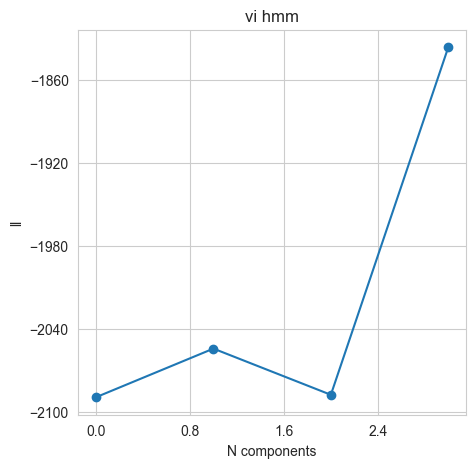

In [41]:
plot_results_dict(inf_vi_ll, 'vi hmm')

In [24]:
from bnpy.allocmodel.hmm.HMMUtil import FwdBwdAlg

log_lik_seq0_TK = goodelbopairs_trained_model.obsModel.calcLogSoftEvMatrix_FromPost(bnpy_dataset_group.make_subset([0]))
_, _, ll = FwdBwdAlg(goodelbopairs_trained_model.allocModel.get_init_prob_vector(), goodelbopairs_trained_model.allocModel.get_trans_prob_matrix(), log_lik_seq0_TK)


In [49]:
from bnpy.obsmodel import GaussObsModel
from bnpy import HModel

def get_hmm_from_bnpy(some_model: HModel, name=None):

    obs_model = some_model.obsModel
    total_k = obs_model.K
    means = []
    sigmas = []
    for k in range(total_k):
        sigmas.append(np.diag(obs_model.get_covar_mat_for_comp(k)))
        means.append(obs_model.get_mean_for_comp(k))

    means = np.vstack(means)
    sigmas = np.vstack(sigmas)

    return_val = {
        'A': some_model.allocModel.get_trans_prob_matrix(),
        'pi': some_model.allocModel.get_init_prob_vector(),
        'alloc': some_model.allocModel.to_dict(),
        'obs': some_model.obsModel.to_dict(),
        'means': means,
        'covars': sigmas
     }

    if name:
        directory_path = "/Users/david/Documents/mastersCode/ubm/final/tests/get_features/"
        file_name = 'humpback_v1_bnpy_' + name + '.pkl'
        output = open(directory_path + file_name, "wb")
        pickle.dump(return_val, output)
        output.close()

    return return_val

hmm_from_bnpy = get_hmm_from_bnpy(goodelbopairs_trained_model)

In [45]:
directory_path = "/Users/david/Documents/mastersCode/ubm/final/tests/get_features/"
file_name = 'humpback_v1_bnpy.pkl'
output = open(directory_path + file_name, "wb")
pickle.dump(hmm_from_bnpy, output)
output.close()

In [19]:
hmmar_trained_model, hmmar_info_dict = bnpy.run(
    dataset, 'HDPHMM', 'AutoRegGauss', 'memoVB',
    output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+AutoRegGauss-ECovMat=1*eye/',
    nLap=50, nTask=1, nBatch=1, convergeThr=0.0001,
    transAlpha=transAlpha, gamma=gamma, sF=sF, ECovMat=ECovMat,
    K=K, initname='randexamples',
    )

Dataset Summary:
GroupXData
  total size: 6 units
  batch size: 6 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Auto-Regressive Gaussian with full covariance.
Obs. Data  Prior:  MatrixNormal-Wishart on each mean/prec matrix pair: A, Lam
  E[ A ] = 
  [[1. 0.]
   [0. 1.]] ...
  E[ Sigma ] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 20 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=HDPHMM+AutoRegGauss-ECovMat=1*eye/1
    1.000/50 after      0 sec. |    279.5 MiB | K   20 | loss  2.908127656e+00 |  
    2.000/50 after      0 sec. |    281.4 MiB | K   20 | loss  2.712797722e+00 | Ndiff   53.407 
    3.000/50 after      0 sec. |    281.4 MiB | K   20 | loss  2.623844667e+00 | Ndiff   51.736 
    4.000/50 after      0 sec. |    289.7 MiB | K   20 | loss  2.579060900e+00 | Ndiff   47.749 
    5.000

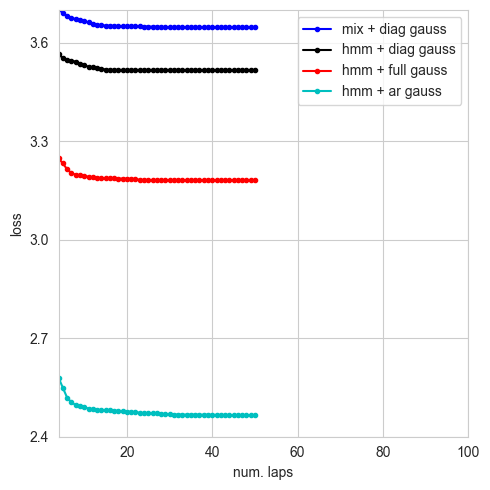

In [13]:
###############################################################################
#
# Compare loss function traces for all methods
# --------------------------------------------
#
pylab.figure()

pylab.plot(
    mixdiag_info_dict['lap_history'],
    mixdiag_info_dict['loss_history'], 'b.-',
    label='mix + diag gauss')
pylab.plot(
    hmmdiag_info_dict['lap_history'],
    hmmdiag_info_dict['loss_history'], 'k.-',
    label='hmm + diag gauss')
pylab.plot(
    hmmfull_info_dict['lap_history'],
    hmmfull_info_dict['loss_history'], 'r.-',
    label='hmm + full gauss')
pylab.plot(
    hmmar_info_dict['lap_history'],
    hmmar_info_dict['loss_history'], 'c.-',
    label='hmm + ar gauss')
pylab.legend(loc='upper right')
pylab.xlabel('num. laps')
pylab.ylabel('loss')
pylab.xlim([4, 100]) # avoid early iterations
pylab.ylim([2.4, 3.7]) # handpicked
pylab.draw()
pylab.tight_layout()